In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

In [2]:
sharks_df = pd.read_csv("./data/attacks.csv", encoding='windows-1252')

In [33]:
pd.set_option('display.expand_frame_repr', False)
sharks_df.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Year_extracted,Month_extracted
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,white shark,2018.0,6.0
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN,2018.0,6.0
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,NaN,2018.0,6.0
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,Minor injury to lower leg,N,NaN,2 m shark,2018.0,6.0
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,"tiger shark, 3m",2018.0,6.0


In [4]:
sharks_df.shape

(25723, 24)

In [5]:
# Dropping non-informative columns

sharks_df.drop(columns=["pdf", "href formula", "href", "Case Number.1", "Case Number.2", "original order", "Investigator or Source", "Unnamed: 22","Unnamed: 23"], inplace=True)

In [6]:
# Dropping the duplicates

sharks_df.drop_duplicates(keep='first', inplace=True)

In [7]:
# Only 6312 shark attack records remain

sharks_df.shape

(6305, 15)

In [8]:
# Un poquito para ver que columnas hay
columnas = [column for column in sharks_df.columns]
columnas

['Case Number',
 'Date',
 'Year',
 'Type',
 'Country',
 'Area',
 'Location',
 'Activity',
 'Name',
 'Sex ',
 'Age',
 'Injury',
 'Fatal (Y/N)',
 'Time',
 'Species ']

In [9]:
sharks_df["Case Number"].str.extract("(\d{4})\.(\d{2})").at[4427, 0]


'1951'

In [10]:
sharks_df["Case Number"].str.extract("(\d{4})\.(\d{2})").at[4427, 1]

'11'

In [11]:
# Get Month and Year from "Case Number"

sharks_df["Year_extracted"] = sharks_df["Case Number"].str.extract("(\d{4})\.(\d{2})")[0]
sharks_df["Month_extracted"] = sharks_df["Case Number"].str.extract("(\d{4})\.(\d{2})")[1]


sharks_df["Month_extracted"] = sharks_df["Month_extracted"].apply(lambda month: np.nan if month == "00" else month)
sharks_df["Month_extracted"] = sharks_df["Month_extracted"].apply(lambda month: np.nan if pd.isnull(month) else np.int64(month))

sharks_df["Year_extracted"] = sharks_df["Year_extracted"].apply(lambda year: np.nan if year == "0000" else year)
sharks_df["Year_extracted"] = sharks_df["Year_extracted"].apply(lambda year: np.nan if pd.isnull(year) else np.int64(year))

In [12]:
# Cleaning "Country"

sharks_df["Country"].value_counts(dropna=False)

USA                      2229
AUSTRALIA                1338
SOUTH AFRICA              579
PAPUA NEW GUINEA          134
NEW ZEALAND               128
                         ... 
THE BALKANS                 1
NORTH ATLANTIC OCEAN        1
MAYOTTE                     1
GABON                       1
CEYLON (SRI LANKA)          1
Name: Country, Length: 213, dtype: int64

In [13]:
# Attempts to cast Year column into Int64
#sharks_df["Year"] = sharks_df["Year"].astype('Int64')
#sharks_df["Year"] = sharks_df["Year"].apply(lambda year: year if pd.isnull(year) else np.int_(year))
#sharks_df["Year"] = sharks_df["Year"].astype('Int64')

In [14]:
# Cleaning column "Fatal (Y/N)"
values_OK_fatal = ["N", "Y", np.nan, "UNKNOWN"]
sharks_df["Fatal (Y/N)"] = sharks_df["Fatal (Y/N)"].apply(lambda string: string if pd.isnull(string) else string.strip().upper())
sharks_df["Fatal (Y/N)"] = sharks_df["Fatal (Y/N)"].apply(lambda value: value if value in values_OK_fatal else np.nan)

In [15]:
# Cleaning column "Sex "
sharks_df["Sex "] = sharks_df["Sex "].apply(lambda string: string if pd.isnull(string) else string.strip().upper())

# values_OK_sex = ["M", "F", np.nan]
# sharks_df[sharks_df["Sex "].apply(lambda value: True if value not in values_OK_sex else False)]

sharks_df.at[1624, "Sex "] = "M"
sharks_df.at[4938, "Sex "] = np.nan
sharks_df.at[5437, "Sex "] = np.nan
sharks_df.at[6131, "Sex "] = "M"

In [36]:
display(sharks_df[["Sex ", "Year_extracted"]].value_counts(dropna=False))

Sex   Year_extracted
M     2015.0            114
      2011.0            109
      NaN               107
      2016.0            105
      2008.0            103
                       ... 
NaN   1617.0              1
      1637.0              1
      1733.0              1
      1776.0              1
F     1791.0              1
Length: 495, dtype: int64

In [16]:
# Cleaning column "Age"
sharks_df["Age"] = sharks_df["Age"].str.extract("(\d{1,2})")

In [17]:
# Cleaning column "Species "
sharks_df["Species "] = sharks_df["Species "].apply(lambda string: string if pd.isnull(string) else string.strip().lower())

In [18]:
#sharks_df["Species "].value_counts(dropna=False).to_csv("./Species.csv", index=True)

In [19]:
species_list = pd.read_csv("./data/shark_species_clean.csv")

In [20]:
# New DataFrame containing only the rows where species is informed
sharks_df_with_species = sharks_df[sharks_df['Species '].notna()]

In [21]:
# Removing rows where the species field contains "no shark" or "nor confirmed"
sharks_df_with_species = sharks_df_with_species[~sharks_df_with_species["Species "].str.contains("no shark", regex=False)]
sharks_df_with_species = sharks_df_with_species[~sharks_df_with_species["Species "].str.contains("not confirmed", regex=False)]

In [22]:
sharks_df_with_species[sharks_df_with_species["Species "].str.contains(species_list.at[845, "Species_list"], regex=False)]

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Year_extracted,Month_extracted
632,2013.08.31.a,31-Aug-2013,2013.0,Unprovoked,USA,California,"Butterfly Beach, Montecito, Santa Barbara County",Swimming,Nick Kennedy,M,NaN,Foot bitten,N,23h00,salmon shark,2013.0,8.0
764,2012.07.19,19-Jul-2012,2012.0,Invalid,CANADA,British Colombia,"Tofino, Vancouver",Surfing,Kaitlin Dakers,F,23,"Lacerations to 2 fingers, but shark involvemen...",NaN,NaN,"salmon shark suspected, but unlikely",2012.0,7.0
2020,2000.08.27.R,Reported 27-Aug-2000,2000.0,Provoked,USA,Alaska,Prince William Sound,Conducting research,Bruce Wright,M,NaN,Leg bitten by netted shark PROVOKED INCIDENT,N,NaN,salmon shark,2000.0,8.0


In [23]:
sharks_df_with_species["Real_Species"] = np.nan

In [24]:
def species_finder(species_column_value):
    for shark in species_list["Species_list"]:
        if shark in species_column_value:
            return shark
    return np.nan

In [25]:
sharks_df_with_species["Real_Species"] = sharks_df_with_species["Species "].apply(species_finder)

In [26]:
with open('./data/shark_dict.pickle', 'rb') as handle:
    shark_dict = pickle.load(handle)

In [27]:
# Applying the dictionary to complete the name of some incomplete species
sharks_df_with_species["Real_Species"] = sharks_df_with_species["Real_Species"].apply(lambda species: shark_dict[species] if species in shark_dict.keys() else species)

In [28]:
# DataFrame with "Real_Species"  and "Fatal (Y/N)" columns, dropping NaNs and "UNKNOWN" values in the Fatality column
fatality_by_species = sharks_df_with_species[["Real_Species", "Fatal (Y/N)"]].dropna(how="any")
fatality_by_species = fatality_by_species[fatality_by_species["Fatal (Y/N)"] != "UNKNOWN"]
fatality_by_species = fatality_by_species.value_counts().unstack()
fatality_by_species["Y"] = fatality_by_species["Y"].fillna(0)
fatality_by_species["Total"] = fatality_by_species["N"]+fatality_by_species["Y"]
fatality_by_species["Fatality_ratio_%"] = (fatality_by_species["Y"]/(fatality_by_species["Total"])*100).round(decimals=2)
fatality_by_species.reset_index(inplace=True)
fatality_by_species.rename({"N": "Non Fatal", "Y": "Fatal"}, axis='columns',  inplace=True)
fatality_by_species["Real_Species"] = fatality_by_species["Real_Species"].apply(lambda string: string if pd.isnull(string) else string.title())
fatality_by_species.set_index("Real_Species", inplace=True)
fatality_by_species

Fatal (Y/N),Non Fatal,Fatal,Total,Fatality_ratio_%
Real_Species,,,,
Angel Shark,6.0,0.0,6.0,0.00
Basking Shark,5.0,2.0,7.0,28.57
Blacktail Reef Shark,1.0,0.0,1.0,0.00
Blacktip Reef Shark,10.0,0.0,10.0,0.00
Blacktip Shark,67.0,0.0,67.0,0.00
Blind Shark,1.0,0.0,1.0,0.00
Blue Shark,43.0,12.0,55.0,21.82
Broadnose Sevengill Shark,2.0,0.0,2.0,0.00
Bronze Whaler Shark,55.0,4.0,59.0,6.78


In [29]:
# Keeping only species that have more than 20 attacks registered
fatality_by_species = fatality_by_species[fatality_by_species["Total"]>20].sort_values(by="Fatal", ascending=False)

<AxesSubplot:xlabel='Real_Species'>

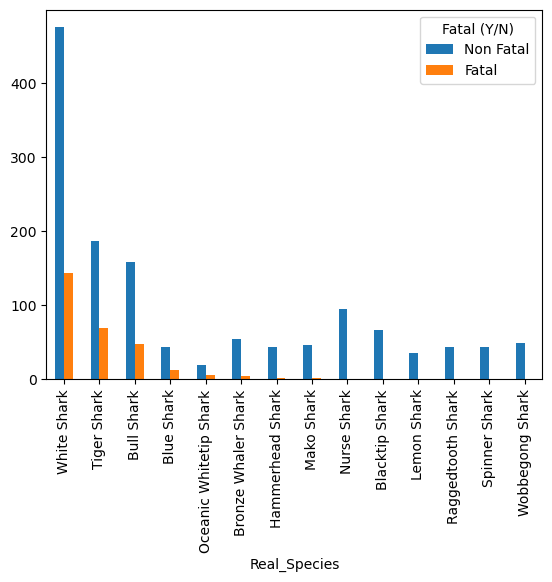

In [38]:
# Total attacks by species
fatality_by_species[["Non Fatal", "Fatal"]].plot(kind="bar", stacked=False)

Text(0.5, 1.0, '% of attacks that resulted in death')

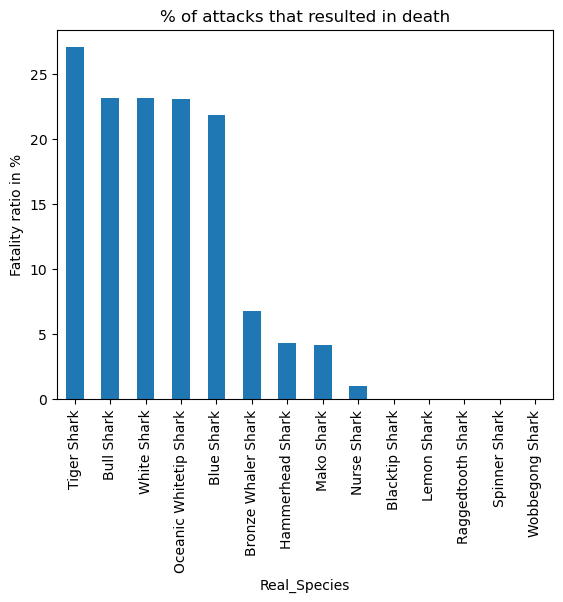

In [31]:
# Most deadly sharks
fatality_by_species["Fatality_ratio_%"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Fatality ratio in %")
plt.title("% of attacks that resulted in death")

In [32]:
#sharks_df.to_csv("./Prueba.csv", index=False)